
# 📈 Forecasting Iowa Liquor Sales



In [118]:
## Install additional packages

!pip install --quiet google-cloud-bigquery pandas-gbq  scikit-learn matplotlib statsmodels prophet scipy

In [119]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=5MJnjN7zouUiHOEZcYfyKyPWrkgGs8&access_type=offline&code_challenge=OU1VDIXOTUoGPILuHBekvbWXZhUpp1IovtIcMySwtss&code_challenge_method=S256


Credentials saved to file: [C:\Users\jarau\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "bqmlproject" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [120]:
dataset_id = "bqmlforecast" # @param {type:"string"}
PROJECT_ID = "bqmlproject"  # @param {type:"string"}
LOCATION = "US"  # @param {type:"string"}
ARIMA_PARAMS = {
    "TRAININGDATA_STARTDATE": "2021-01-01",
    "TRAININGDATA_ENDDATE": "2024-05-31",
    "TESTDATA_STARTDATE": "2024-06-01",
    "TESTDATA_ENDDATE": "2024-06-30"
}

In [121]:

### Set Google Cloud project information"""

"""### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.
"""

!gcloud config set project $PROJECT_ID

BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}"

"""**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket."""

! gsutil mb -l $LOCATION $BUCKET_URI
! bq mk --location=US --dataset bqmlproject:bqmlforecast



Updated property [core/project].
Creating gs://your-bucket-name-bqmlproject/...
ServiceException: 409 A Cloud Storage bucket named 'your-bucket-name-bqmlproject' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [123]:
##**Load the required libraries.**
import sys
import os

# Get the parent directory (two levels up in this case)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

import matplotlib.pyplot as plt
import numpy as np
np.float_=np.float64
from google.cloud import bigquery
from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error, mean_squared_error)
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from prophet import Prophet
from scripts.project_utils import *

import warnings
warnings.filterwarnings("ignore")

In [124]:
# Initialize the BigQuery client
client = bigquery.Client(project=PROJECT_ID)

In [125]:
query = """
SELECT
   *
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
LIMIT 5
"""
job = client.query(query)
job.to_dataframe()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,RINV-04926400042,2023-10-27,3626,WAL-MART 2714 / SPENCER,500 11TH ST,SPENCER,51301.0,POINT(-95.152458015 43.125130009),None,CLAY,...,11788,BLACK VELVET,6,1750,11.00,16.50,-24,-396.00,-42.0,-11.09
1,RINV-04830100119,2023-09-05,2505,HY-VEE WINE AND SPIRITS (1038) / BOONE,1111 8TH ST,BOONE,50036.0,POINT(-93.876089041 42.064806014),None,BOONE,...,39423,NEW AMSTERDAM PINK WHITNEY,12,1000,8.00,12.00,-12,-144.00,-12.0,-3.17
2,RINV-04792400109,2023-08-07,5102,WILKIE LIQUORS,724 1ST STREET NE,MOUNT VERNON,52314.0,POINT(-91.410777025 41.918154015),None,LINN,...,65750,DON AGAVE GOLD,12,1000,5.84,8.76,-12,-105.12,-12.0,-3.17
3,RINV-04736900142,2023-07-07,4129,CYCLONE LIQUORS,626 LINCOLN WAY,AMES,50010.0,POINT(-93.618248037 42.021326987),None,STORY,...,82637,DEKUYPER GRAPE PUCKER,12,1000,7.87,11.81,-12,-141.72,-12.0,-3.17
4,RINV-05042000096,2023-12-21,5236,"GIGGLE JUICE LIQUOR STATION, LLC",600 W. MAIN ST.,ANAMOSA,52205.0,POINT(-91.290921006 42.108513993),None,JONES,...,86887,SOUTHERN COMFORT,12,1000,12.97,19.46,-12,-233.52,-12.0,-3.17


In [126]:
# Create training and test data tables
create_data_table(client, PROJECT_ID, dataset_id, "training_data", ARIMA_PARAMS["TRAININGDATA_STARTDATE"], ARIMA_PARAMS["TRAININGDATA_ENDDATE"])
create_data_table(client, PROJECT_ID, dataset_id, "test_data", ARIMA_PARAMS["TESTDATA_STARTDATE"], ARIMA_PARAMS["TESTDATA_ENDDATE"])

Table bqmlforecast.training_data created.
Table bqmlforecast.test_data created.


In [128]:
query = f"""
SELECT
    date,
    item_name,
    total_amount_sold
FROM
    {dataset_id}.training_data
ORDER BY item_name, date
"""
df_historical = client.query(query).to_dataframe()
df_historical.head()

,date,item_name,total_amount_sold
0,2021-01-04,BLACK VELVET,3080
1,2021-01-05,BLACK VELVET,3563
2,2021-01-06,BLACK VELVET,2554
3,2021-01-07,BLACK VELVET,2344
4,2021-01-08,BLACK VELVET,5053


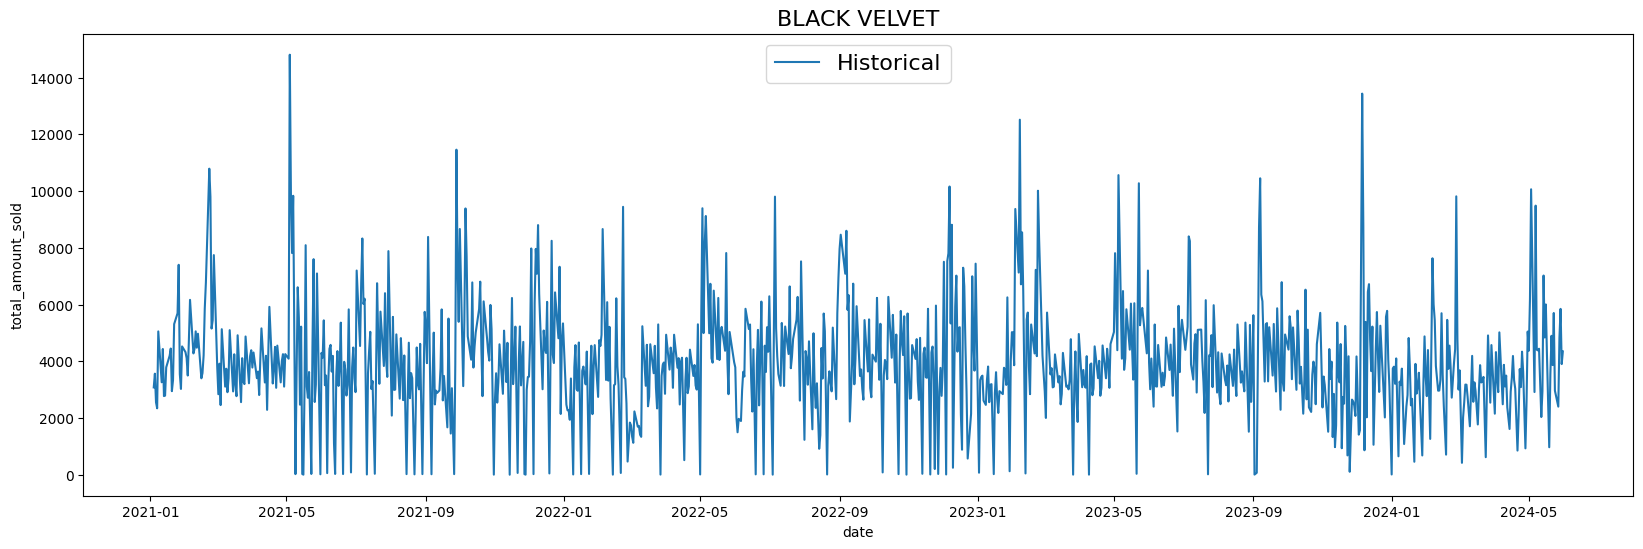

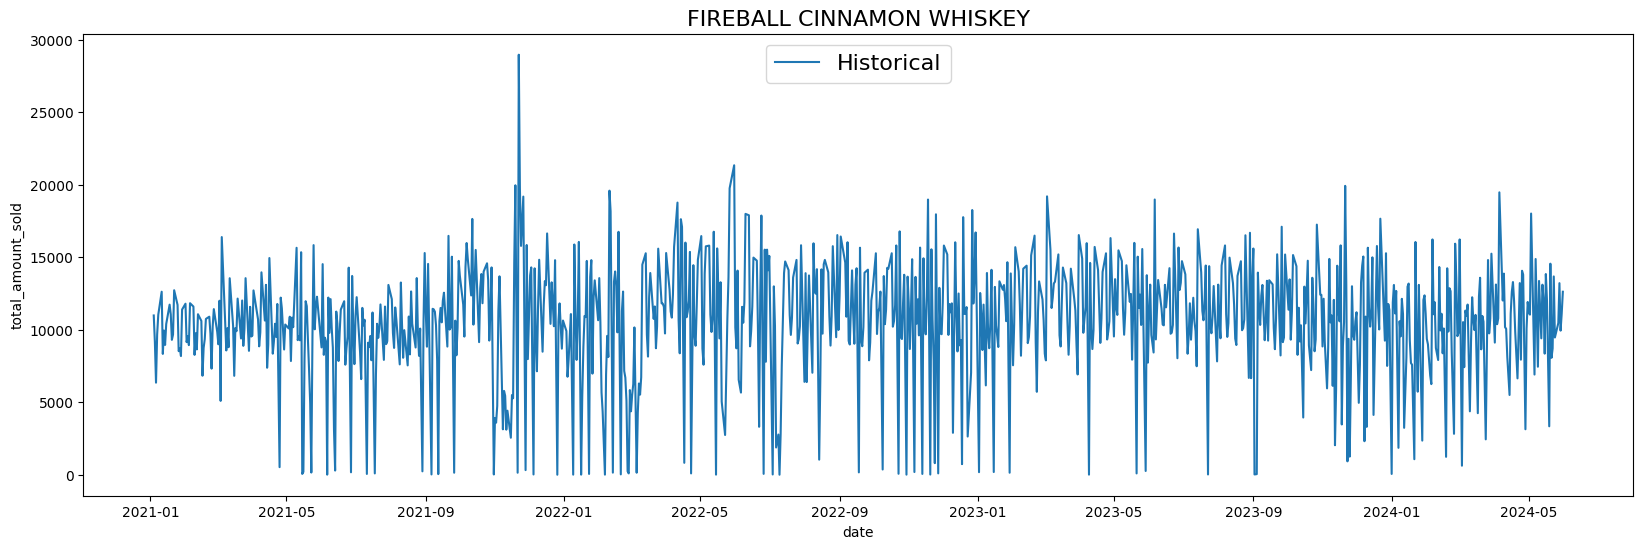

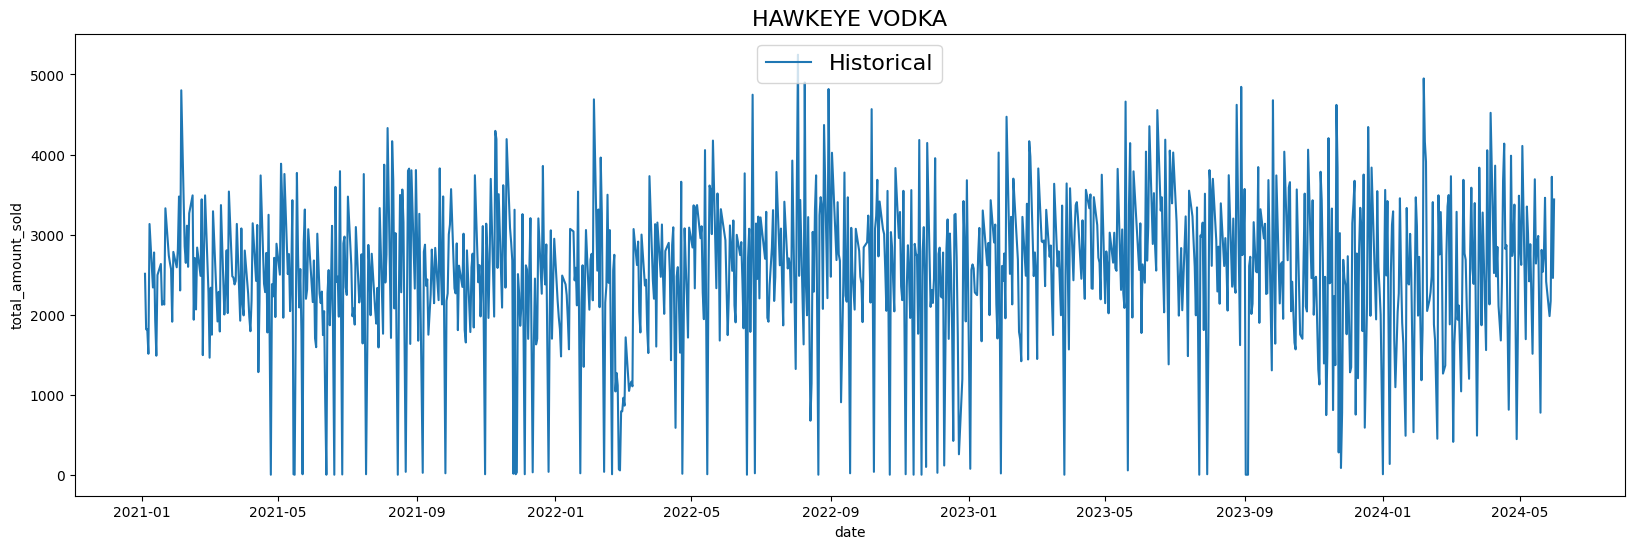

In [ ]:
itemslist = list(df_historical.item_name.unique())

for item in itemslist:

    datah = df_historical[df_historical.item_name==item]
    plot_historical_and_forecast(input_timeseries = datah,
                                 timestamp_col_name = "date",
                                 data_col_name = "total_amount_sold",
                                 forecast_output = None,
                                 actual = None,
                                 title = item)

In [129]:
# Test stationarity for each item
itemslist = list(df_historical.item_name.unique())
for item in itemslist:
    data = df_historical[df_historical.item_name == item]['total_amount_sold']
    print(f'Stationarity test for {item}:')
    test_stationarity(data)
    print('\n')


Stationarity test for BLACK VELVET:
Results of Dickey-Fuller Test:
Test Statistic                -9.483480e+00
p-value                        3.817353e-16
#Lags Used                     8.000000e+00
Number of Observations Used    9.690000e+02
Critical Value (1%)           -3.437116e+00
Critical Value (5%)           -2.864527e+00
Critical Value (10%)          -2.568361e+00
dtype: float64
The time series is stationary.


Stationarity test for FIREBALL CINNAMON WHISKEY:
Results of Dickey-Fuller Test:
Test Statistic                -1.008894e+01
p-value                        1.135669e-17
#Lags Used                     5.000000e+00
Number of Observations Used    9.690000e+02
Critical Value (1%)           -3.437116e+00
Critical Value (5%)           -2.864527e+00
Critical Value (10%)          -2.568361e+00
dtype: float64
The time series is stationary.


Stationarity test for HAWKEYE VODKA:
Results of Dickey-Fuller Test:
Test Statistic                -8.508209e+00
p-value                      

In [136]:
# Create ARIMA model
create_arima_model(client, dataset_id, "arima_model")

Model bqmlforecast.arima_model created.


In [137]:
# Forecast using the model
dfforecast = forecast_model(client, dataset_id, "arima_model", horizon=30, confidence_level=0.9)

In [138]:
# Define the query to evaluate the ARIMA model
query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{dataset_id}.arima_model`),
    (SELECT
    date,
    item_name,
    total_amount_sold
FROM
    {dataset_id}.training_data)
"""

# Execute the query
query_job = client.query(query)

# Fetch the results
results = query_job.result()

# Convert results to a DataFrame
df = results.to_dataframe()

In [139]:
query = f"""
SELECT
    *
FROM
    {dataset_id}.test_data
"""
dfactual = client.query(query).to_dataframe()

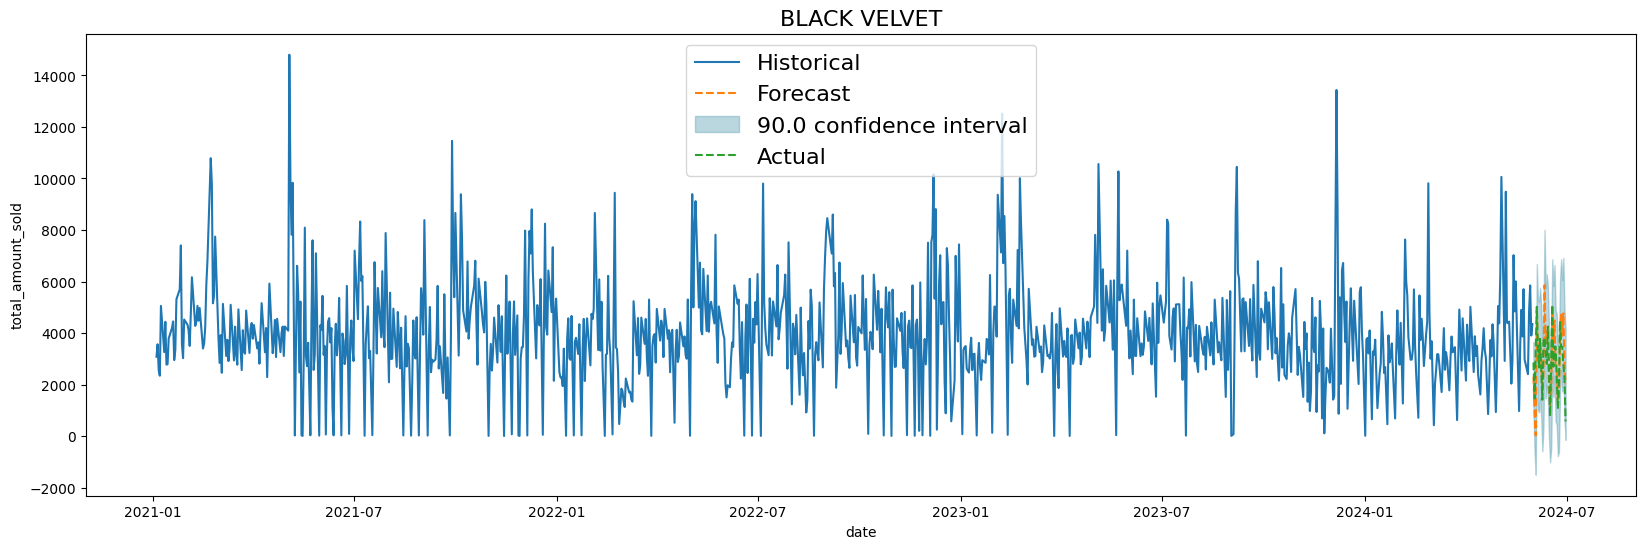

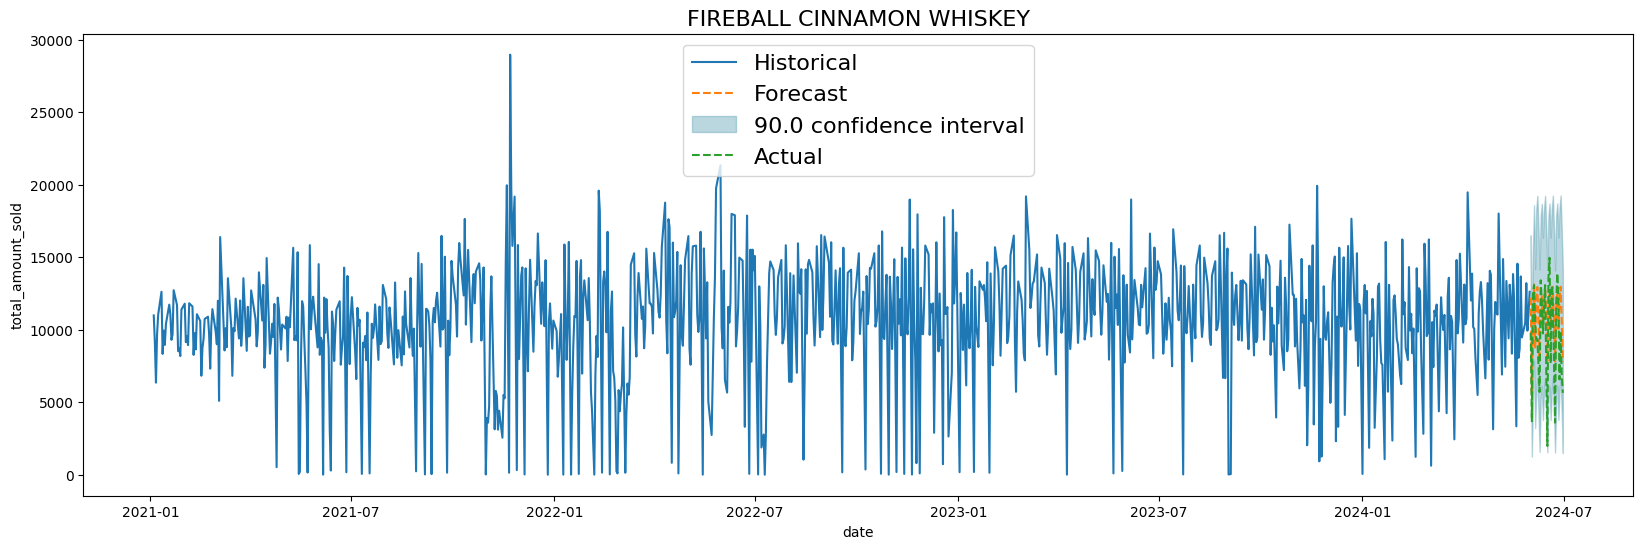

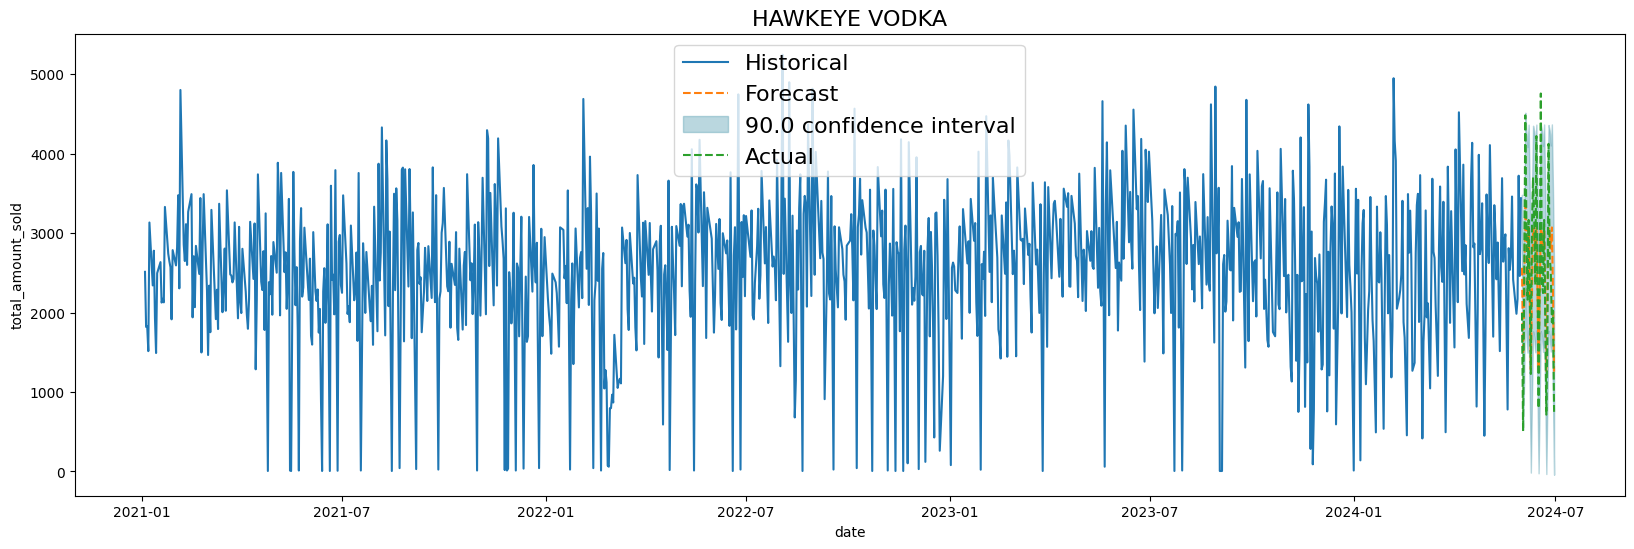

In [141]:
# Plot historical and forecast data
itemslist = list(df_historical.item_name.unique())
for item in itemslist:
    datah = df_historical[df_historical.item_name==item].copy()
    dataf = dfforecast[dfforecast.item_name==item].copy()
    dataa = dfactual[dfactual.item_name==item].copy()

    plot_historical_and_forecast(input_timeseries = datah,
                                 timestamp_col_name = "date",
                                 data_col_name = "total_amount_sold",
                                 forecast_output = dataf,
                                 actual = dataa,
                                 title = item,
                                 plotstartdate = "2021-01-01")

In [142]:
# Evaluate the model
print(f'Error metrics for ARIMA Train:')

errors_df = evaluate_model(df, df_historical)
print(errors_df)

print()

print(f'Error metrics for ARIMA Test:')

errors_df = evaluate_model(dfactual, dfforecast)
print(errors_df)



Error metrics for ARIMA Train:
                   item_name          MAE        MAPE           MSE  \
0               BLACK VELVET  2717.156153   43.192832  1.959658e+07   
1              HAWKEYE VODKA  3213.073728   36.784967  2.708009e+07   
2  FIREBALL CINNAMON WHISKEY  4903.459441  187.762506  4.361031e+07   

          RMSE      SMAPE  
0  4426.802830  44.913606  
1  5203.853372  54.989788  
2  6603.810361  70.468876  

Error metrics for ARIMA Test:
                   item_name          MAE       MAPE           MSE  \
0  FIREBALL CINNAMON WHISKEY  2128.155831  35.953973  6.713819e+06   
1              HAWKEYE VODKA   562.400707  31.043960  4.784633e+05   
2               BLACK VELVET   843.856444  37.244573  1.226847e+06   

          RMSE      SMAPE  
0  2591.103765  25.220037  
1   691.710430  25.379915  
2  1107.631394  34.340396  


18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:54 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing


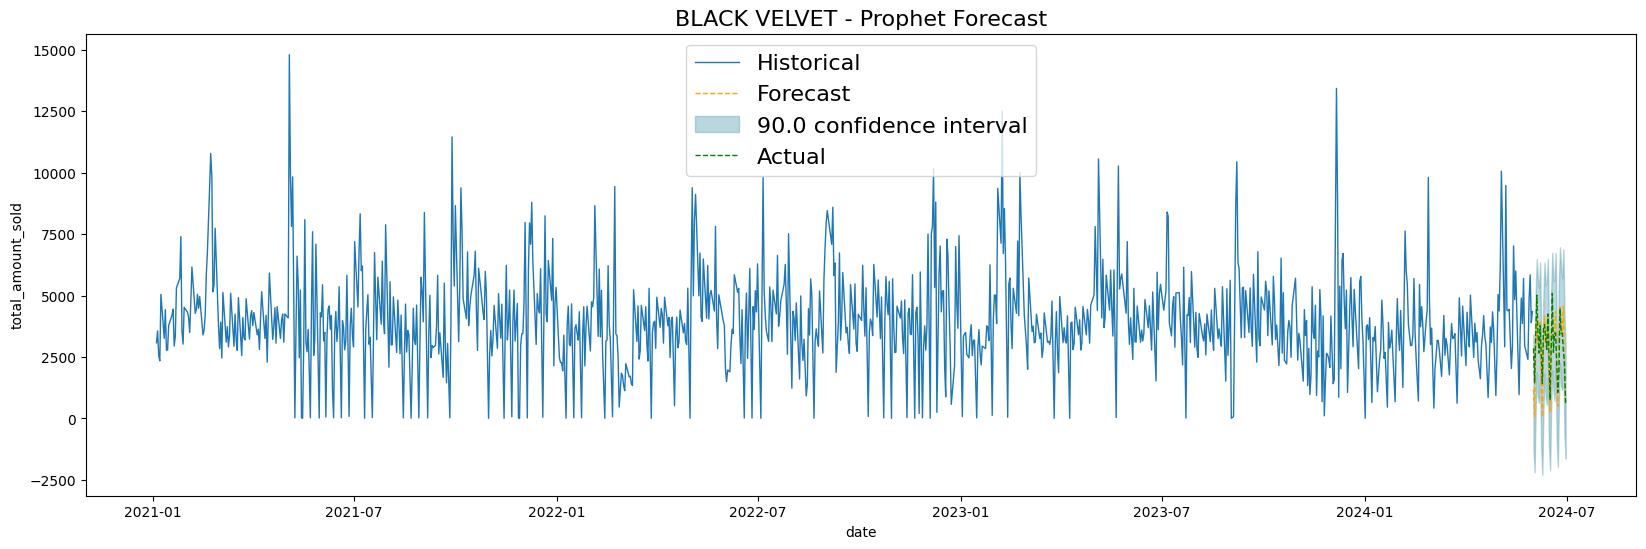

18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing
18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing


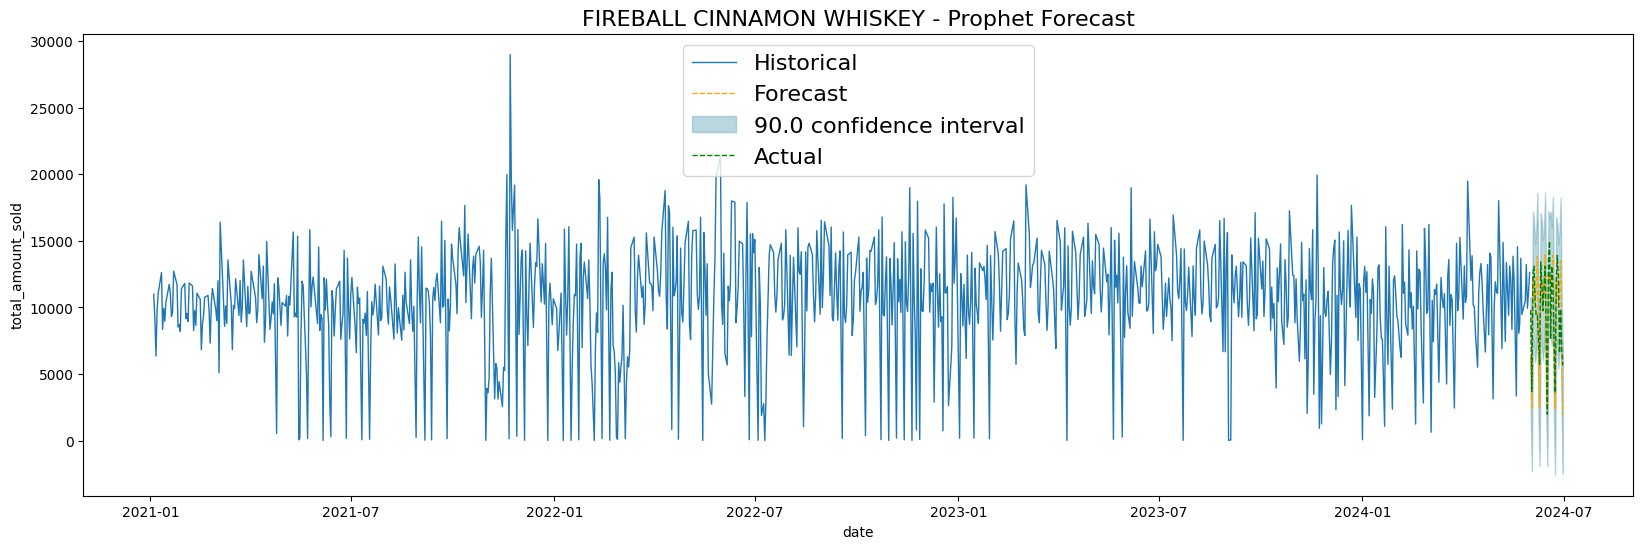

18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:59 - cmdstanpy - INFO - Chain [1] start processing
18:06:59 - cmdstanpy - INFO - Chain [1] done processing


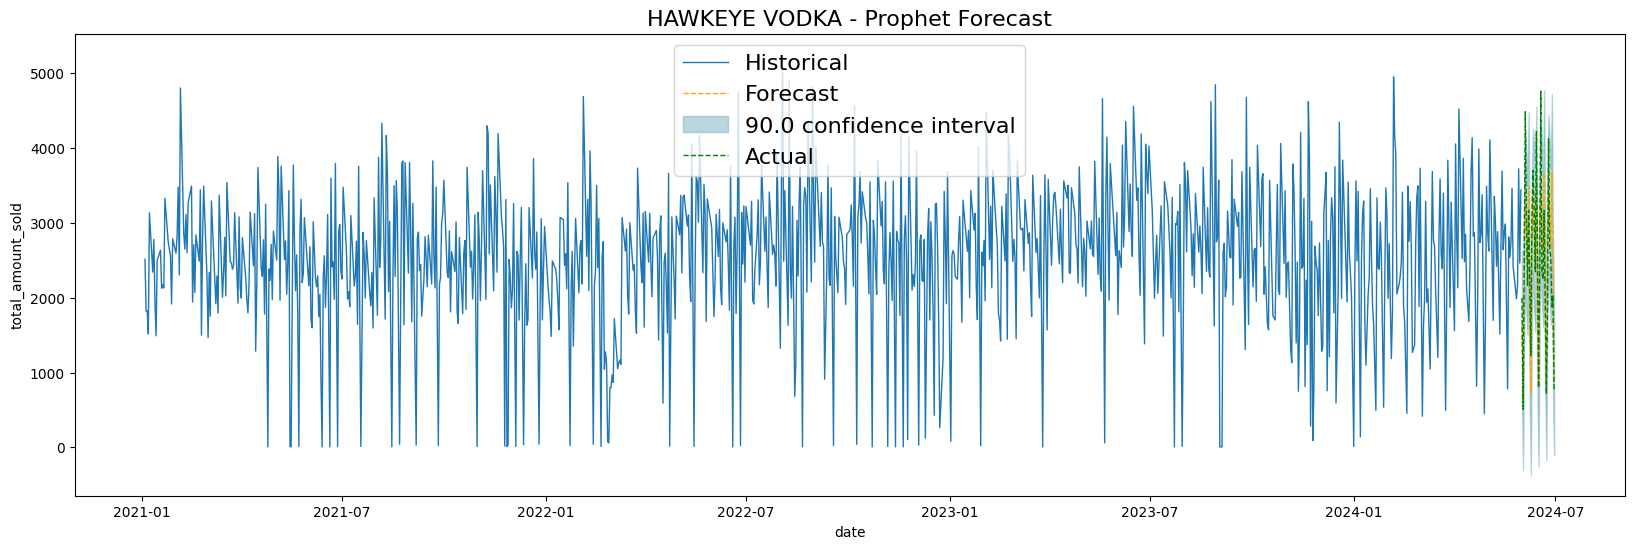

In [143]:
# Hyperparameter grid for Prophet tuning
param_grid = [
    {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0},
    {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.0},
    {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 30.0},
    {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 40.0}
]
prophet_fcast_list = list()
itemslist = list(df_historical.item_name.unique())
for item in itemslist:
    data = df_historical[df_historical.item_name==item][['date', 'total_amount_sold', 'item_name']].copy()
    _, prophet_forecast = tune_prophet_model(data, param_grid)
    prophet_fcast_list.append(prophet_forecast)
    plot_historical_and_forecastprophet(input_timeseries=data,
                                 timestamp_col_name="date",
                                 data_col_name="total_amount_sold",
                                 forecast_output=prophet_forecast,
                                 actual=dfactual[dfactual.item_name==item].copy(),
                                 title=f'{item} - Prophet Forecast',
                                 plotstartdate="2021-01-01")
prophet_fcast=pd.concat(prophet_fcast_list)

In [144]:
# Evaluate the best Prophet model
errors_df_prophet = evaluate_profetmodel(df_historical, prophet_fcast)
print(f'Error metrics for Prophet Train:')
print(errors_df_prophet)
print()
errors_df_prophet = evaluate_profetmodel(dfactual, prophet_fcast)
print(f'Error metrics for Prophet Test:')
print(errors_df_prophet)

Error metrics for Prophet Train:
                   item_name          MAE        MAPE           MSE  \
0               BLACK VELVET  3078.138173  372.782688  1.883363e+07   
1  FIREBALL CINNAMON WHISKEY  5634.497621  177.140352  4.702626e+07   
2              HAWKEYE VODKA  3381.710672  514.344187  2.485965e+07   

          RMSE      SMAPE  
0  4339.773609  59.814923  
1  6857.569531  80.347374  
2  4985.945356  68.864960  

Error metrics for Prophet Test:
                   item_name          MAE        MAPE           MSE  \
0  FIREBALL CINNAMON WHISKEY  5436.779405   56.789993  4.131355e+07   
1              HAWKEYE VODKA  2822.628313  119.935612  2.172467e+07   
2               BLACK VELVET  2695.805263   94.060743  1.937265e+07   

          RMSE      SMAPE  
0  6427.561508  86.949503  
1  4660.973048  57.638676  
2  4401.436724  54.390630  


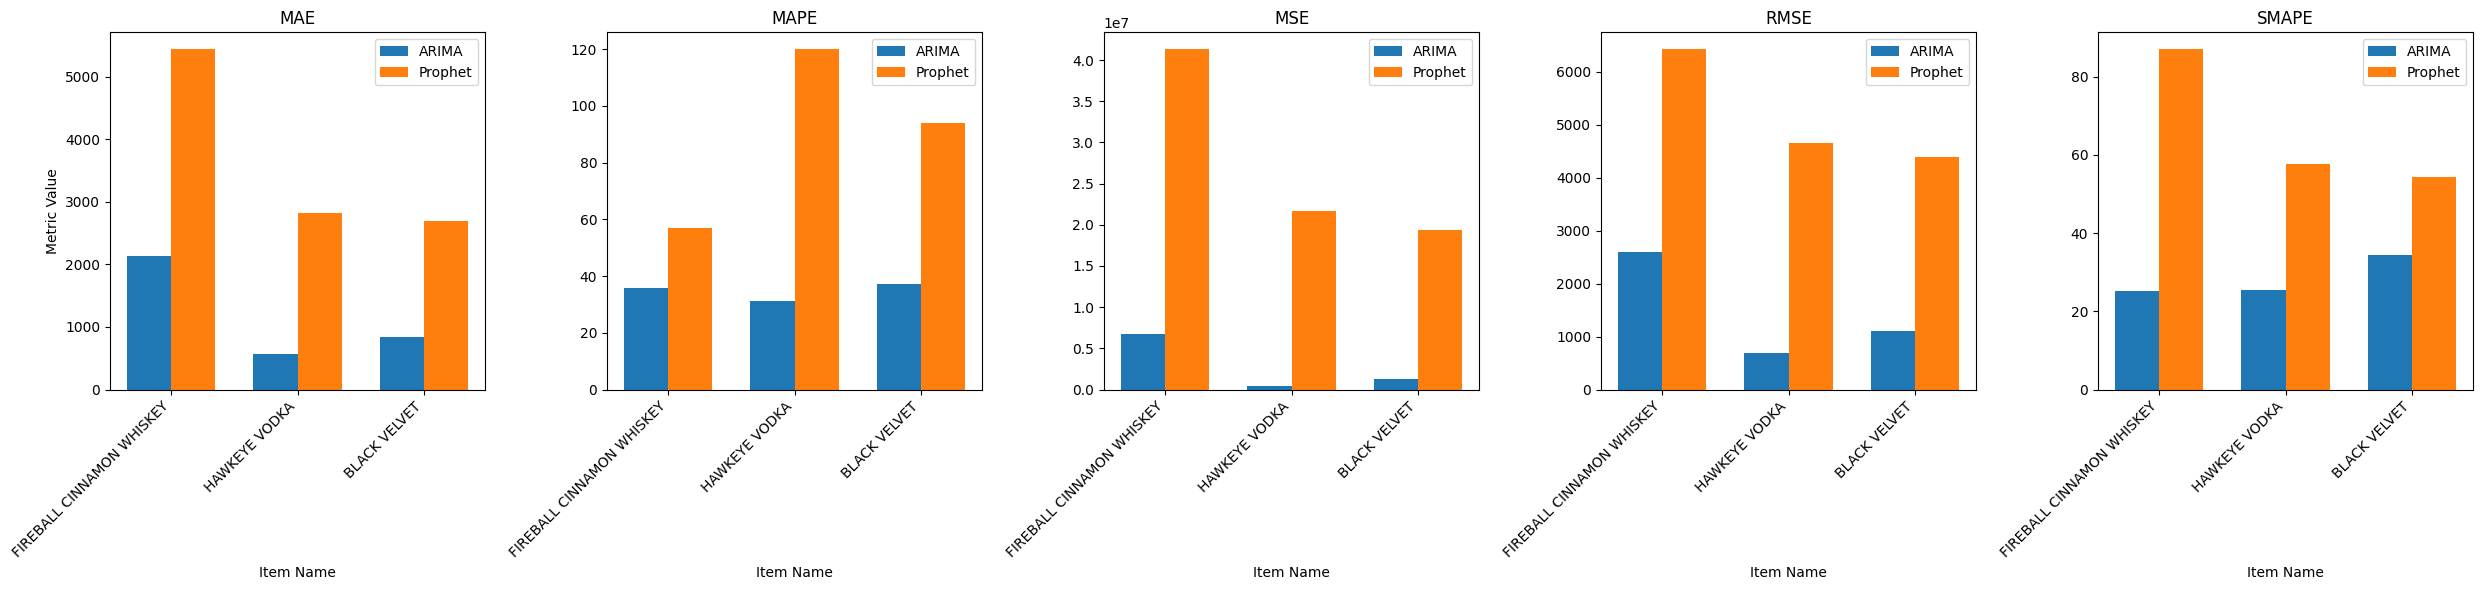

In [145]:
# Combine ARIMA and Prophet evaluation metrics for comparison
metrics_comparison = pd.merge(errors_df, errors_df_prophet, on='item_name', suffixes=('_ARIMA', '_Prophet'))
# Plot the metrics comparison
metrics = ['MAE', 'MAPE', 'MSE', 'RMSE', 'SMAPE']
fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize=(25, 6), sharey=False)

bar_width = 0.35
index = range(len(metrics_comparison['item_name']))

for i, metric in enumerate(metrics):
    axs[i].bar(index, metrics_comparison[f'{metric}_ARIMA'], bar_width, label='ARIMA')
    axs[i].bar([p + bar_width for p in index], metrics_comparison[f'{metric}_Prophet'], bar_width, label='Prophet')

    axs[i].set_title(metric)
    axs[i].set_xlabel('Item Name')
    axs[i].set_xticks([p + bar_width / 2 for p in index])
    axs[i].set_xticklabels(metrics_comparison['item_name'], rotation=45, ha='right')
    axs[i].legend()

axs[0].set_ylabel('Metric Value')

plt.tight_layout()
plt.show()

In [146]:
# Realizando o teste t para comparar MAE, MAPE, MSE, RMSE e SMAPE entre ARIMA e Prophet
metrics = ['MAE', 'MAPE', 'MSE', 'RMSE', 'SMAPE']
t_test_results = {}

for metric in metrics:
    t_stat, p_value = stats.ttest_rel(metrics_comparison[f'{metric}_ARIMA'], metrics_comparison[f'{metric}_Prophet'])

    # Verificar se a diferença é significativa
    significance = 'Significant' if p_value < 0.05 else 'Not Significant'

    t_test_results[metric] = {
        't_stat': t_stat,
        'p_value': p_value,
        'Significance': significance,
    }

# Convertendo os resultados para DataFrame para exibir
t_test_df = pd.DataFrame(t_test_results).T
print(t_test_df)

          t_stat   p_value     Significance
MAE    -5.701794  0.029409      Significant
MAPE   -2.824202  0.105841  Not Significant
MSE    -4.885987  0.039428      Significant
RMSE  -17.907687  0.003104      Significant
SMAPE  -3.072748  0.091594  Not Significant


In [147]:
# Call the function to create the training data table and train the ARIMA model
# The function returns a success message upon completion
result = create_and_train_arima_model(PROJECT_ID, dataset_id, 'training_data', 'arima_model')

# Print the success message to confirm that the ARIMA model was created and trained
print(result)


ARIMA model created and trained successfully.


In [148]:
# Call the function to create the forecast table, insert forecast data, export the data to Google Cloud Storage,
# and return both a success message and the forecast data as a DataFrame.
# Note: Billing needs to be enabled for this project to run BigQuery operations and export data to Google Cloud Storage.

message, result_df = create_and_insert_forecast_data(PROJECT_ID, dataset_id, 'forecast', 'arima_model', f'{BUCKET_URI}/arima_forecast*.csv')

# Print the success message to confirm that the forecast data table was created, data was inserted,
# and the data was exported successfully.
print(message)

# Optionally, you can print the first few rows of the DataFrame to inspect the data
print(result_df.head())

Forecast data table created, data inserted, and exported successfully.
         forecast_timestamp                  item_name  forecast_value  \
0 2024-08-01 00:00:00+00:00               BLACK VELVET     1953.377889   
1 2024-08-01 00:00:00+00:00  FIREBALL CINNAMON WHISKEY     8759.704842   
2 2024-08-01 00:00:00+00:00              HAWKEYE VODKA     2023.093739   
3 2024-08-02 00:00:00+00:00               BLACK VELVET     2015.723967   
4 2024-08-02 00:00:00+00:00  FIREBALL CINNAMON WHISKEY     8012.622367   

     run_date  
0  2024-08-10  
1  2024-08-10  
2  2024-08-10  
3  2024-08-10  
4  2024-08-10  


## Clean up



In [149]:
# Set dataset variable to the ID of the dataset to fetch.
dataset = f"{PROJECT_ID}.{dataset_id}"

# Use the delete_contents parameter to delete a dataset and its contents.
# Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
client.delete_dataset(
    dataset_id, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(dataset_id))

# Delete Cloud Storage objects that were created
delete_bucket = True  # Set True for deletion
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI

Deleted dataset 'bqmlforecast'.


Removing gs://your-bucket-name-bqmlproject/arima_forecast000000000000.csv#1723324115417133...
/ [1/1 objects] 100% Done                                                       

Operation completed over 1 objects.                                              
Removing gs://your-bucket-name-bqmlproject/...
